In [90]:
import utils
import math
import numpy as np 
import shutil

from torchvision.models.resnet import *
import torchvision
import torch

import matplotlib
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog

import pandas as pd
from split_image import split_image



#load dataset
dataset = torchvision.datasets.Caltech101("../CSE515-Project/")
labels_caltech_101 = np.array([dataset[i][1] for i in range(len(dataset))])
downdata_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=8)
print(len(dataset))

print(labels_caltech_101)


8677
[  0   0   0 ... 100 100 100]


 Task 2a: Implement a program which, given (a) a query imageID or image file, (b) a user selected feature space, and
(c) positive integer k, identifies and lists k most likely matching labels, along with their scores, under the selected
feature space.

Key for selecting query type and feature space type

Query Type- 
- i : Image ID Query
- f: Image File Query

Feature Space Type- 
- 1 : Color Moment
- 2 : HoG
- 3 : ResNet-AvgPool-1024
- 4 : ResNet-Layer3-1024
- 5 : ResNet-FC-1000

In [115]:
#Get inputs for Task 2:
#type of query, feature space, k
valid = False
img = dataset[0][0]

#print(utils.extract_hog_features(dataset[0][0])[1].shape)
'''
queryTypeDict = {"i": "Image ID Query", "f" : "Image File Query"}
featureSpaceTypeDict = {"1": "Color Moment", "2": "HoG", "3" : "ResNet-AvgPool-1024", "4" : "ResNet-Layer3-1024", "5" : "ResNet-FC-1000"}

queryType = input("Enter \"i\" for image ID query, and \"f\" for image file query")
if(queryType != "i" and queryType != "f"):
    while(not valid):
        queryType = input("Please enter a valid query type:\nEnter \"i\" for image ID query, and \"f\" for image file query")
        if(queryType == "i" or queryType == "f"):
            valid = True
print("Input type: " + queryTypeDict[queryType])


if queryType == "i":
    caltechID = input("Enter an image ID (from 0-8676)")
    img = dataset[int(caltechID)][0]
'''
#caltechID = input("Enter an image ID (from 0-8676)")
#img = dataset[int(caltechID)][0]

''' 
imageFileName = input("Please enter the path for the desired image")
img = imread(imageFileName)
plt.imshow(img)
plt.show()
'''
#print("Shape:" + str(img.shape))

'''
valid = False
featureSpaceType = input("Enter the number to the feature space you would like to use: (1) Color Moment; (2) HoG; (3) ResNet-AvgPool-1024; (4) ResNet-Layer3-1024; (5) ResNet-FC-1000")
if(featureSpaceType != "1" and featureSpaceType != "2" and featureSpaceType != "3" and featureSpaceType != "4"and featureSpaceType != "5"):
    while(not valid):
        featureSpaceType = input("Please enter a valid query type:\nEnter the number to the feature space you would like to use: (1) Color Moment; (2) HoG; (3) ResNet-AvgPool-1024; (4) ResNet-Layer3-1024; (5) ResNet-FC-1000")
        if(featureSpaceType == "1" or featureSpaceType == "2" or featureSpaceType == "3" or featureSpaceType == "4" or featureSpaceType == "5"):
            valid = True
print("Feature Space type: " + featureSpaceTypeDict[featureSpaceType])
'''



(300, 100)


'\nvalid = False\nfeatureSpaceType = input("Enter the number to the feature space you would like to use: (1) Color Moment; (2) HoG; (3) ResNet-AvgPool-1024; (4) ResNet-Layer3-1024; (5) ResNet-FC-1000")\nif(featureSpaceType != "1" and featureSpaceType != "2" and featureSpaceType != "3" and featureSpaceType != "4"and featureSpaceType != "5"):\n    while(not valid):\n        featureSpaceType = input("Please enter a valid query type:\nEnter the number to the feature space you would like to use: (1) Color Moment; (2) HoG; (3) ResNet-AvgPool-1024; (4) ResNet-Layer3-1024; (5) ResNet-FC-1000")\n        if(featureSpaceType == "1" or featureSpaceType == "2" or featureSpaceType == "3" or featureSpaceType == "4" or featureSpaceType == "5"):\n            valid = True\nprint("Feature Space type: " + featureSpaceTypeDict[featureSpaceType])\n'

In [92]:
def colorMoment(img):
    #resize image
    imOpen = np.asarray(img)

    resizedImg = resize(imOpen, (100,300))
    #plt.imshow(resizedImg)
    #plt.show()
    #print("Shape:" + str(resizedImg.shape))
    matplotlib.image.imsave('resized.jpg', resizedImg)


    #partition images into 10x10 grid
    splitDir = "./split"
    os.makedirs(splitDir)
    split_image('./resized.jpg', 10, 10, False, False, True, splitDir)


    colorMoment = torch.Tensor(10, 10, 3, 3) 
    #iterate through grid    squares and calculate the color moment for each
    xGrid = 0
    yGrid = 0
    for gridSquare in os.listdir(splitDir):
        if xGrid >= 10:
            xGrid = 0
            yGrid += 1
        
        gridImg = imread(splitDir + '/' + gridSquare)
        rAvg = 0
        gAvg = 0
        bAvg = 0

        #calculate mean
        for x in range(gridImg.shape[1]):
            for y in range(gridImg.shape[0]):
                rAvg += gridImg[y][x][0]
                gAvg += gridImg[y][x][1]
                bAvg += gridImg[y][x][2]

        rAvg = rAvg/300
        gAvg = gAvg/300
        bAvg = bAvg/300

        #calculage standard deviation and skew
        rStdDevSum = 0
        gStdDevSum = 0
        bStdDevSum = 0

        rSkewSum = 0
        gSkewSum = 0
        bSkewSum = 0

        for x in range(gridImg.shape[1]):
            for y in range(gridImg.shape[0]):
                rStdDevSum += pow(gridImg[y][x][0] - rAvg, 2)
                gStdDevSum += pow(gridImg[y][x][1] - gAvg, 2)
                bStdDevSum += pow(gridImg[y][x][2] - bAvg, 2)

                rSkewSum += pow(gridImg[y][x][0] - rAvg, 3)
                gSkewSum += pow(gridImg[y][x][1] - gAvg, 3)
                bSkewSum += pow(gridImg[y][x][2] - bAvg, 3)

        rStdDev = math.sqrt(rStdDevSum/300)
        gStdDev = math.sqrt(gStdDevSum/300)
        bStdDev = math.sqrt(bStdDevSum/300)

        rSkew = np.cbrt((rSkewSum/300))
        gSkew = np.cbrt((gSkewSum/300))
        bSkew = np.cbrt((bSkewSum/300))

        colorMoment[xGrid][yGrid][0] = torch.tensor([rAvg, rStdDev, rSkew])
        colorMoment[xGrid][yGrid][1] = torch.tensor([gAvg, gStdDev, gSkew])
        colorMoment[xGrid][yGrid][2] = torch.tensor([bAvg, bStdDev, bSkew])

        xGrid += 1

    #remove temporary files
    shutil.rmtree(splitDir)
    os.remove("resized.jpg")

    return colorMoment

def hogFunct(img):
      
	#resize image
    imOpen = np.asarray(img)
	#imOpen = np.asarray(dataset[id][0])

    resizedImg = resize(imOpen, (100,300))
    matplotlib.image.imsave('resized.jpg', resizedImg)

    resized_hog_img_np = imread('./resized.jpg')
    grayscaleResizedHogImg = cv2.cvtColor(resized_hog_img_np,cv2.COLOR_BGR2GRAY)
    plt.show()

    cv2.imwrite("greyscaleImg.png", grayscaleResizedHogImg)
    os.remove("resized.jpg")

    gridIm = imread("greyscaleImg.png")
    fd, hog_image = hog(gridIm, orientations=9, pixels_per_cell=(10,30),
                        cells_per_block=(1, 1), visualize=True, channel_axis=None, feature_vector=False)
    #plt.axis("off")
    #plt.imshow(hog_image, cmap="gray")
    #print(fd.shape)

    os.remove("greyscaleImg.png")

    hogTensor = torch.Tensor(10,10,9)
    for y in range(10):
        for x in range(10):
            hogTensor[x][y] = torch.tensor(fd[x][y][0][0])
    return hogTensor

def resnetAvgPool(img):
    #dictionary storing layer outputs
    layer_outputs = {
        'layer3': [],
        'avgpool': [],
        'fc': []
    }

    def get_intermediate_outputs(layer):
        def hook(model, input, output):
            layer_outputs[layer] = output.detach()
        return hook

    #resize image
    imOpen = np.asarray(img)

    resizedImg = resize(imOpen, (224,224))
    matplotlib.image.imsave('resized.jpg', resizedImg)
    resizedImgNp = imread('./resized.jpg')

    npDataset = torch.tensor([np.transpose(resizedImgNp)])
    #print("Shape:" + str(npDataset.shape))

    rn_model =  torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    rn_model.eval()
    rn_model.avgpool.register_forward_hook(get_intermediate_outputs('avgpool'))
    rn_model(npDataset.float())

    avgpoolAveraged = torch.Tensor(1,1024) 

    #average out avgpool layer
    for i in range(1024):
        avgpoolAveraged[0][i] = (layer_outputs['avgpool'][0][2 * i][0][0] + layer_outputs['avgpool'][0][2 * i + 1][0][0])/2
    layer_outputs['avgpool'] = avgpoolAveraged

    #print(layer_outputs['avgpool'].shape)
    os.remove("resized.jpg")

    return layer_outputs['avgpool']

def resnetfc(img):
    #dictionary storing layer outputs
    layer_outputs = {
        'layer3': [],
        'avgpool': [],
        'fc': []
    }

    def get_intermediate_outputs(layer):
        def hook(model, input, output):
            layer_outputs[layer] = output.detach()
        return hook

    #resize image
    imOpen = np.asarray(img)

    resizedImg = resize(imOpen, (224,224))
    #print("Shape:" + str(resizedImg.shape))
    matplotlib.image.imsave('resized.jpg', resizedImg)
    resizedImgNp = imread('./resized.jpg')

    npDataset = torch.tensor([np.transpose(resizedImgNp)])
    #print("Shape:" + str(npDataset.shape))

    rn_model =  torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    rn_model.eval()
    rn_model.fc.register_forward_hook(get_intermediate_outputs('fc'))
    rn_model(npDataset.float())

    #print(layer_outputs['fc'].shape)

    os.remove("resized.jpg")

    return layer_outputs['fc']

def resnetLayer3(img):
    #dictionary storing layer outputs
    layer_outputs = {
        'layer3': [],
        'avgpool': [],
        'fc': []
    }

    def get_intermediate_outputs(layer):
        def hook(model, input, output):
            layer_outputs[layer] = output.detach()
        return hook

    #resize image
    imOpen = np.asarray(img)

    resizedImg = resize(imOpen, (224,224))
    matplotlib.image.imsave('resized.jpg', resizedImg)
    resizedImgNp = imread('./resized.jpg')

    npDataset = torch.tensor([np.transpose(resizedImgNp)])
    #print("Shape:" + str(npDataset.shape))

    rn_model =  torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    rn_model.eval()
    rn_model.layer3.register_forward_hook(get_intermediate_outputs('layer3'))
    rn_model(npDataset.float())

    #average slices of layer3
    layer3Averaged = torch.Tensor.numpy(layer_outputs['layer3'])
    layer3Averaged = np.mean(layer3Averaged, axis = (2,3))
    layer_outputs['layer3'] = torch.tensor(layer3Averaged)

    #print(layer_outputs['layer3'].shape)
    os.remove("resized.jpg")

    return layer_outputs['layer3']

In [93]:
#load existing output data
colorMomentDict = torch.load("ptOutputs/colorMoment_output.pt")
hogDict = torch.load("ptOutputs/hog_output.pt")
avgpoolDict = torch.load("ptOutputs/avgpool_output.pt")
fcDict = torch.load("ptOutputs/fc_output.pt")
layer3Dict = torch.load("ptOutputs/layer3_output.pt")

def calculateColorMomentDistanceVector(count):
    colorMomentCurrent = colorMoment(dataset[int(caltechID)][0])

    #create list of tupes (id, distance), sorted by distance from lowest to highest
    kSimilarImage = []
    for i in range(count):
        dist = np.linalg.norm(torch.Tensor.numpy(colorMomentCurrent) - torch.Tensor.numpy(colorMomentDict[str(i)]))
        kSimilarImage.append((i, dist))
        #print(dist)
    kSimilarImage.sort(key = lambda x:x[1])

    for i in range(count, len(dataset)):
        dist = np.linalg.norm(torch.Tensor.numpy(colorMomentCurrent) - torch.Tensor.numpy(colorMomentDict[str(i)]))
        if dist < kSimilarImage[count-1][1]:
            kSimilarImage.pop()
            kSimilarImage.append((i, dist))
            kSimilarImage.sort(key = lambda x:x[1])

    fig = plt.figure(figsize=(10, 7))
    plt.axis('off')

    for i in range(count):
        fig.add_subplot(5, 2, i+1)
        im =  np.asarray(dataset[kSimilarImage[i][0]][0])
        plt.axis('off')
        plt.imshow(im)
        plt.title(kSimilarImage[i][0])

    return kSimilarImage

def calculateHOGDistanceVector(count):
    hogCurrent = hogFunct(dataset[int(caltechID)][0])

    #create list of tupes (id, distance), sorted by distance from lowest to highest
    kSimilarImage = []
    for i in range(count):
        dist = np.linalg.norm(hogCurrent - torch.Tensor.numpy(hogDict[str(i)]))
        kSimilarImage.append((i, dist))
        #print(dist)
    kSimilarImage.sort(key = lambda x:x[1])

    for i in range(count, len(dataset)):
        dist = np.linalg.norm(torch.Tensor.numpy(hogCurrent) - torch.Tensor.numpy(hogDict[str(i)]))
        if dist < kSimilarImage[count-1][1]:
            kSimilarImage.pop()
            kSimilarImage.append((i, dist))
            kSimilarImage.sort(key = lambda x:x[1])

    fig = plt.figure(figsize=(10, 7))
    plt.axis('off')

    for i in range(count):
        fig.add_subplot(5, 2, i+1)
        im =  np.asarray(dataset[kSimilarImage[i][0]][0])
        plt.axis('off')
        plt.imshow(im)
        plt.title(kSimilarImage[i][0])

    return kSimilarImage

def calculateAvgpoolDistanceVector(count):
    avgpoolCurrent = resnetAvgPool(dataset[int(caltechID)][0])
    
    #create list of tupes (id, distance), sorted by distance from lowest to highest
    kSimilarImage = []
    for i in range(count):
        dist = np.linalg.norm(torch.Tensor.numpy(avgpoolCurrent) - torch.Tensor.numpy(avgpoolDict[str(i)]))
        kSimilarImage.append((i, dist))
        #print(dist)
    kSimilarImage.sort(key = lambda x:x[1])

    for i in range(count, len(dataset)):
        dist = np.linalg.norm(torch.Tensor.numpy(avgpoolCurrent) - torch.Tensor.numpy(avgpoolDict[str(i)]))
        if dist < kSimilarImage[count-1][1]:
            kSimilarImage.pop()
            kSimilarImage.append((i, dist))
            kSimilarImage.sort(key = lambda x:x[1])

    fig = plt.figure(figsize=(10, 7))
    plt.axis('off')

    for i in range(count):
        fig.add_subplot(5, 2, i+1)
        im =  np.asarray(dataset[kSimilarImage[i][0]][0])
        plt.axis('off')
        plt.imshow(im)
        plt.title(str(i+1) + ") " + str(kSimilarImage[i][0]))
    return kSimilarImage

def calculateFcDistanceVector(count):
    fcDictCurrent = resnetfc(dataset[int(caltechID)][0])
    
    #create list of tupes (id, distance), sorted by distance from lowest to highest
    kSimilarImage = []
    for i in range(count):
        dist = np.linalg.norm(torch.Tensor.numpy(fcDictCurrent) - torch.Tensor.numpy(fcDict[str(i)]))
        kSimilarImage.append((i, dist))
        #print(dist)
    kSimilarImage.sort(key = lambda x:x[1])

    for i in range(count, len(dataset)):
        dist = np.linalg.norm(torch.Tensor.numpy(fcDictCurrent) - torch.Tensor.numpy(fcDict[str(i)]))
        if dist < kSimilarImage[count-1][1]:
            kSimilarImage.pop()
            kSimilarImage.append((i, dist))
            kSimilarImage.sort(key = lambda x:x[1])

    fig = plt.figure(figsize=(10, 7))
    plt.axis('off')

    for i in range(count):
        fig.add_subplot(5, 2, i+1)
        im =  np.asarray(dataset[kSimilarImage[i][0]][0])
        plt.axis('off')
        plt.imshow(im)
        plt.title(kSimilarImage[i][0])

    return kSimilarImage

def calculateLayer3DistanceVector(count):
    layer3DictCurrent = resnetLayer3(dataset[int(caltechID)][0])

    #create list of tupes (id, distance), sorted by distance from lowest to highest
    kSimilarImage = []
    for i in range(count):
        dist = np.linalg.norm(torch.Tensor.numpy(layer3DictCurrent) - torch.Tensor.numpy(layer3Dict[str(i)]))
        kSimilarImage.append((i, dist))
        #print(dist)
    kSimilarImage.sort(key = lambda x:x[1])

    for i in range(count, len(dataset)):
        dist = np.linalg.norm(torch.Tensor.numpy(layer3DictCurrent) - torch.Tensor.numpy(layer3Dict[str(i)]))
        if dist < kSimilarImage[count-1][1]:
            kSimilarImage.pop()
            kSimilarImage.append((i, dist))
            kSimilarImage.sort(key = lambda x:x[1])

    fig = plt.figure(figsize=(10, 7))
    plt.axis('off')

    for i in range(count):
        fig.add_subplot(5, 2, i+1)
        im =  np.asarray(dataset[kSimilarImage[i][0]][0])
        plt.axis('off')
        plt.imshow(im)
        plt.title(kSimilarImage[i][0])

    return kSimilarImage

#calculateHOGDistanceVector(3)
#calculateColorMomentDistanceVector(3)
#calculateFcDistanceVector(3)
#calculateAvgpoolDistanceVector(3)
#calculateLayer3DistanceVector(3)

#img = imread("./13.png")
#print(colorMoment(img))


In [94]:
#functions to calculate cluster labels
def calculateColorMomentCluster():
    colorMomentCluster = {}
    labelNum = 0
    clusterNpArray = np.array([colorMomentDict[str(0)].numpy().flatten()])
    for i in range(1,len(dataset)):
        if labels_caltech_101[i] == labelNum:
            #clusterNpArray = np.stack((clusterNpArray, colorMomentDict[str(i)].numpy().flatten()))
            clusterNpArray = np.vstack((clusterNpArray, np.array([colorMomentDict[str(i)].numpy().flatten()])))
        else: 
            #print(clusterNpArray.shape)
            colorMomentCluster[str(labelNum)] = clusterNpArray.mean(axis = 0)
            clusterNpArray = np.array([colorMomentDict[str(i)].numpy().flatten()])
            labelNum = labels_caltech_101[i]

    torch.save(colorMomentCluster, "ptOutputs/colorMoment_labelValues.pt")
    
    print(colorMomentCluster)
    print(colorMomentCluster['0'].shape)

def calculateHOGCluster():
    HOGCluster = {}
    labelNum = 0
    clusterNpArray = np.array([hogDict[str(0)].numpy().flatten()])
    for i in range(1,len(dataset)):
        if labels_caltech_101[i] == labelNum:
            clusterNpArray = np.vstack((clusterNpArray, np.array([hogDict[str(i)].numpy().flatten()])))
        else: 
            #print(clusterNpArray.shape)
            HOGCluster[str(labelNum)] = clusterNpArray.mean(axis = 0)
            clusterNpArray = np.array([hogDict[str(i)].numpy().flatten()])
            labelNum = labels_caltech_101[i]

    torch.save(HOGCluster, "ptOutputs/hog_labelValues.pt")
    
    print(HOGCluster)

def calculateAvgPoolCluster():
    avgPoolCluster = {}
    labelNum = 0
    clusterNpArray = np.array([avgpoolDict[str(0)].numpy().flatten()])
    for i in range(1,len(dataset)):
        if labels_caltech_101[i] == labelNum:
            clusterNpArray = np.vstack((clusterNpArray, np.array([avgpoolDict[str(i)].numpy().flatten()])))
        else: 
            #print(clusterNpArray.shape)
            avgPoolCluster[str(labelNum)] = clusterNpArray.mean(axis = 0)
            clusterNpArray = np.array([avgpoolDict[str(i)].numpy().flatten()])
            labelNum = labels_caltech_101[i]

    torch.save(avgPoolCluster, "ptOutputs/avgpool_labelValues.pt")
    
    print(avgPoolCluster)

def calculateLayer3Cluster():
    layer3Cluster = {}
    labelNum = 0
    clusterNpArray = np.array([layer3Dict[str(0)].numpy().flatten()])
    for i in range(1,len(dataset)):
        if labels_caltech_101[i] == labelNum:
            clusterNpArray = np.vstack((clusterNpArray, np.array([layer3Dict[str(i)].numpy().flatten()])))
        else: 
            #print(clusterNpArray.shape)
            layer3Cluster[str(labelNum)] = clusterNpArray.mean(axis = 0)
            clusterNpArray = np.array([layer3Dict[str(i)].numpy().flatten()])
            labelNum = labels_caltech_101[i]

    torch.save(layer3Cluster, "ptOutputs/layer3_labelValues.pt")
    
    print(layer3Cluster)

def calculateFcCluster():
    fcCluster = {}
    labelNum = 0
    clusterNpArray = np.array([fcDict[str(0)].numpy().flatten()])
    for i in range(1,len(dataset)):
        if labels_caltech_101[i] == labelNum:
            clusterNpArray = np.vstack((clusterNpArray, np.array([fcDict[str(i)].numpy().flatten()])))
        else: 
            #print(clusterNpArray.shape)
            fcCluster[str(labelNum)] = clusterNpArray.mean(axis = 0)
            clusterNpArray = np.array([fcDict[str(i)].numpy().flatten()])
            labelNum = labels_caltech_101[i]

    torch.save(fcCluster, "ptOutputs/fc_labelValues.pt")
    
    print(fcCluster)

#calculate and save results of all clusters (have been previously run and outputs are stored)
#calculateColorMomentCluster()
#calculateHOGCluster()
#calculateAvgPoolCluster()
#calculateLayer3Cluster()
#calculateFcCluster()



In [95]:
colorMoment_labels = torch.load("ptOutputs/colorMoment_labelValues.pt")
hog_labels = torch.load("ptOutputs/hog_labelValues.pt")
avgpool_labels = torch.load("ptOutputs/avgpool_labelValues.pt")
layer3_labels = torch.load("ptOutputs/layer3_labelValues.pt")
fc_labels = torch.load("ptOutputs/fc_labelValues.pt")

#print(colorMoment_labels['4'])
#print(colorMoment_labels['0'])

[(23, 616.4088745117188), (57, 620.2101440429688), (84, 629.7005004882812), (13, 636.115478515625), (22, 644.5693359375), (87, 653.618408203125), (35, 670.5612182617188), (67, 672.082275390625), (46, 673.640625), (14, 678.177978515625)]


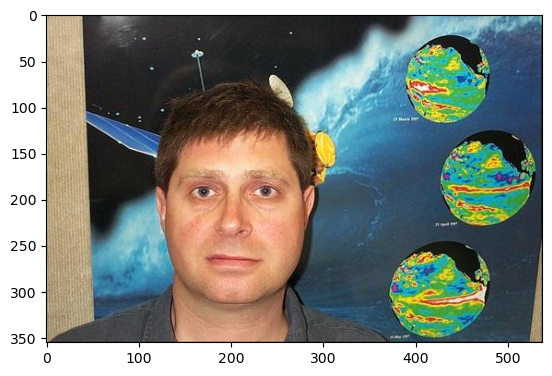

0


In [112]:
def getKMatchingLabels(img, k, model):
    kSimilarLabels = []
    if(model == "1"): #color moment
        colorMomentResult = colorMoment(img).flatten()
        for i in range(k):
            #euclidean distance
            diff = np.linalg.norm(colorMoment_labels[str(i)] - torch.Tensor.numpy(colorMomentResult))
            kSimilarLabels.append((i, diff.item()))
        kSimilarLabels.sort(key = lambda x:x[1])
        #print(kSimilarLabels)

        for i in range(k, 100):
            diff = np.linalg.norm(colorMoment_labels[str(i)] - torch.Tensor.numpy(colorMomentResult))
            if diff < kSimilarLabels[k-1][1]:
                kSimilarLabels.pop()
                kSimilarLabels.append((i, diff.item()))
                kSimilarLabels.sort(key = lambda x:x[1])
        print(kSimilarLabels)      
    elif(model == "2"): #hog
        hogResults = hogFunct(img).flatten()
        for i in range(k):
            #euclidean distance
            diff = np.linalg.norm(hog_labels[str(i)] - torch.Tensor.numpy(hogResults))
            kSimilarLabels.append((i, diff.item()))
        kSimilarLabels.sort(key = lambda x:x[1])
        #print(kSimilarLabels)

        for i in range(k, 100):
            diff = np.linalg.norm(hog_labels[str(i)] - torch.Tensor.numpy(hogResults))
            if diff < kSimilarLabels[k-1][1]:
                kSimilarLabels.pop()
                kSimilarLabels.append((i, diff.item()))
                kSimilarLabels.sort(key = lambda x:x[1])
        print(kSimilarLabels)
    elif(model == "3"): #avgpool
        avgpoolResult = resnetAvgPool(img).flatten()
        for i in range(k):
            #euclidean distance
            diff = np.linalg.norm(avgpool_labels[str(i)] - torch.Tensor.numpy(avgpoolResult))
            kSimilarLabels.append((i, diff.item()))
        kSimilarLabels.sort(key = lambda x:x[1])
        #print(kSimilarLabels)

        for i in range(k, 100):
            diff = np.linalg.norm(avgpool_labels[str(i)] - torch.Tensor.numpy(avgpoolResult))
            if diff < kSimilarLabels[k-1][1]:
                kSimilarLabels.pop()
                kSimilarLabels.append((i, diff.item()))
                kSimilarLabels.sort(key = lambda x:x[1])
        print(kSimilarLabels)
    elif(model == "4"): #layer 3
        layer3Results = resnetLayer3(img).flatten()
        for i in range(k):
            #euclidean distance
            diff = np.linalg.norm(layer3_labels[str(i)] - torch.Tensor.numpy(layer3Results))
            kSimilarLabels.append((i, diff.item()))
        kSimilarLabels.sort(key = lambda x:x[1])
        #print(kSimilarLabels)

        for i in range(k, 100):
            diff = np.linalg.norm(layer3_labels[str(i)] - torch.Tensor.numpy(layer3Results))
            if diff < kSimilarLabels[k-1][1]:
                kSimilarLabels.pop()
                kSimilarLabels.append((i, diff.item()))
                kSimilarLabels.sort(key = lambda x:x[1])
        print(kSimilarLabels)
    elif(model == "5"): #fc
        fcResults = resnetfc(img).flatten()
        for i in range(k):
            #euclidean distance
            diff = np.linalg.norm(fc_labels[str(i)] - torch.Tensor.numpy(fcResults))
            kSimilarLabels.append((i, diff.item()))
        kSimilarLabels.sort(key = lambda x:x[1])
        #print(kSimilarLabels)

        for i in range(k, 100):
            diff = np.linalg.norm(fc_labels[str(i)] - torch.Tensor.numpy(fcResults))
            if diff < kSimilarLabels[k-1][1]:
                kSimilarLabels.pop()
                kSimilarLabels.append((i, diff.item()))
                kSimilarLabels.sort(key = lambda x:x[1])
        print(kSimilarLabels) 

imgId = 3
img = dataset[imgId][0]
#getKMatchingLabels(imread("13.png"), 10, "1")
getKMatchingLabels(img, 10, "5")

plt.imshow(img)
plt.show()
print(labels_caltech_101[imgId])

In [97]:
path = "../CSE515-Project"

def getResnet50Label(id):
#resize image
    imOpen = np.asarray(dataset[id][0])

    resizedImg = resize(imOpen, (224,224))
    #print("Shape:" + str(resizedImg.shape))
    matplotlib.image.imsave('resized.jpg', resizedImg)
    resizedImgNp = imread(path + '/resized.jpg')

    npDataset = torch.tensor([np.transpose(resizedImgNp)])
    #print("Shape:" + str(npDataset.shape))

    rn_model =  torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    rn_model.eval()
    rn_model(npDataset.float())
    print(rn_model)

#getResnet50Label(id)